# Übung 2

### 2.1 Profitvorhersage für ein Franchise-Unternehmen (Lineare Regression)
Ein Unternehmen hat ein Systemgastronomiekonzept mit Imbisswagen entwickelt und in verschiedenen Städten ausprobiert. Die Daten, die in dieser Entwicklungsphase erhoben wurden, sollen dazu genutzt werden, um erzielbare Profite an verschiedenen potentiellen Standorten (Städten) vorherzusagen. Diese Vorhersagen sollen der Unternehmensführung dazu dienen, in besonders gewinnträchtigen Städten gezielt um Franchisenehmer zu werben. Dabei interessiert sich das Unternehmen besonders für die Profitchancen in kleinen und mittelgroßen Städten.

**Daten:**

Die Daten enthalten ein Feature (die Anzahl der Einwohner einer Stadt \[in Einheiten von 10000 Einwohnern\]) und ein Label (der erzielte Gewinn pro Imbisswagen in der Stadt \[in Einheiten von 10000 Euro\]).

**Ihre Aufgaben:**

(1) Importieren Sie die Daten und visualisieren Sie in einem Scatterplot den erzielten Gewinn pro Imbisswagen (y-Achse) und die Anzahl der Einwohner der Stadt (x-Achse). Beschriften Sie die Achsen und machen Sie sich noch einmal klar, in welchen Einheiten die Daten vorliegen.

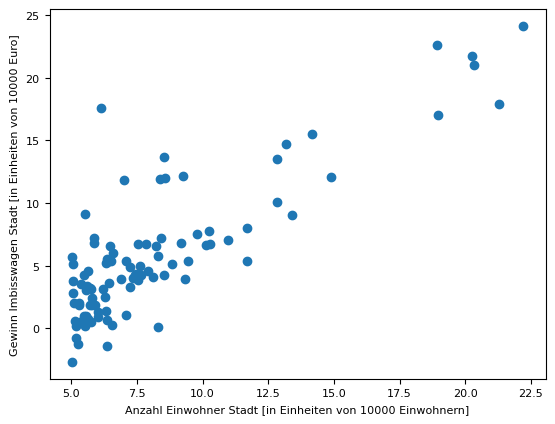

In [165]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams.update({'font.size': 8})

# Sie finden diese Daten auch zum Download unter: https://data.bialonski.de/ml/franchise-data.txt
X_2_1, y_2_1 = np.loadtxt('https://data.bialonski.de/ml/franchise-data.txt', delimiter=',', unpack=True)
# X -> Populationsgröße [in Einheiten von 10000]
# y -> Profit pro Imbisswagen [in Einheiten von 10000 Euro]
plt.scatter(X_2_1,y_2_1)
plt.xlabel('Anzahl Einwohner Stadt [in Einheiten von 10000 Einwohnern]')
plt.ylabel('Gewinn Imbisswagen Stadt [in Einheiten von 10000 Euro]')
plt.show()

(2) Implementieren Sie den "Algorithmus" für *lineare Regression*, wie Sie ihn in der Vorlesung kennengelernt haben. Ihre Funktion trägt den Namen `lin_reg`, nimmt Features $X$ und Labels $y$ entgegen, konstruiert die Matrizen $\text{X}$ und $\text{X}^\dagger$, und gibt die finale Hypothese als Gewichtsvektor $w_\text{lin}$ zurück. 

Hinweise:
* Schlagen Sie noch einmal die Definition des Hypothesensets für lineare Regression in den Vorlesungsfolien nach. Sie sehen, dass dort ebenfalls $x_0=1$ gesetzt wird (wie im Falle der linearen Klassifikation mithilfe des Perzeptrons). Sie müssen dies innerhalb Ihrer Funktion `lin_reg` berücksichtigen und behandeln (beispielsweise mithilfe von [`concatenate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html)).
* Die Funktionen [`dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) und [`linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) werden Ihnen ebenfalls hilfreich sein.

In [166]:
def lin_reg(X,y):
    x = np.column_stack((np.ones((X.shape[0],1)),X))
    x_inv = np.linalg.inv(x.T @ x) @ x.T
    return x_inv @ y
    

(3) Visualisieren Sie nun in einem Scatterplot sowohl die Daten als auch die finale Hypothese, d.h. die durch $w_\text{lin}$ definierte Gerade. Dazu müssen Sie zunächst eine Geradengleichung aus dem Gewichtsvektor $w_\text{lin}$ gewinnen. Sie können noch einmal in den Vorlesungsfolien nachschlagen, wie das Hypothesenset für lineare Regression definiert ist, um zu überlegen, wie Sie aus $w_\text{lin}$ eine Geradengleichung gewinnen können.

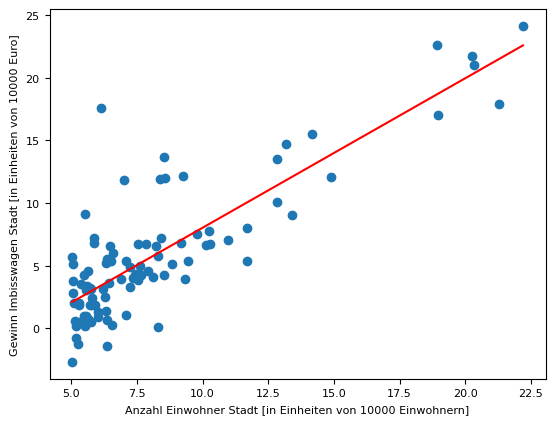

In [167]:
def p(w):
    def p(x):
        return w[0] + w[1]*x
    return p

w = lin_reg(X_2_1, y_2_1)

plt.plot([np.amin(X_2_1), np.amax(X_2_1)], p(w)(np.array([np.amin(X_2_1),np.amax(X_2_1)])), c='red')
plt.scatter(X_2_1,y_2_1)
plt.xlabel('Anzahl Einwohner Stadt [in Einheiten von 10000 Einwohnern]')
plt.ylabel('Gewinn Imbisswagen Stadt [in Einheiten von 10000 Euro]')
plt.show()

(4) Nutzen Sie Ihr Modell, um die Profitchancen für eine Stadt mit 35000 Einwohnern sowie mit 70000 Einwohnern vorherzusagen. Geben Sie Ihre vorhergesagten Profite an.

In [168]:
def predict(w,x):
    return p(w)(x/10000)

print(f'Profitchancen für eine Stadt mit 35.000 Einwohner: {predict(w,35000) * 10000}')
print(f'Profitchancen für eine Stadt mit 70.000 Einwohner: {predict(w,70000) * 10000}')

Profitchancen für eine Stadt mit 35.000 Einwohner: 2798.3687635170986
Profitchancen für eine Stadt mit 70.000 Einwohner: 44554.546310152975


### 2.2 Der Pocket-Algorithmus (Klassifikation bei nicht gegebener linearen Separierbarkeit)

Sie haben bisher PLA kennengelernt, der uns hilft, linear separierbare Daten mithilfe eines Perzeptrons zu charakterisieren. Allerdings terminiert PLA nicht, falls die Daten nicht mehr lineare separierbar sind. Durch Rauschkontaminationen oder durch inhärente Nichtlinearitäten haben Sie allerdings oft mit Datensätzen zu tun, die nicht mehr linear separierbar sind. Sie lernen in dieser Aufgabe den Pocket-Algorithmus kennen, der in diesen Fällen immer noch ein Perzeptron an die Daten fitten kann. 

Der Pocket-Algorithmus führt einen Lernschritt mithilfe des Perzeptron-Lern-Algorithmus (PLA) durch und prüft, ob der In-Sample-Fehler nach dem Lernschritt kleiner geworden ist. Falls dem so ist, merkt sich der Pocket-Algorithmus das (er "steckt den Gewichtsvektor des Perzeptron in seine Tasche" (engl. "pocket")) und führt den nächsten PLA-Schritt durch. Wenn der Prozess am Ende abgebrochen wird, befindet sich in seiner Tasche der Gewichtsvektor (und damit die Gerade), die die Daten am besten (d.h. mit kleinstem In-Sample-Fehler) separiert.

**Hier ist der Algorithmus:**

Sei $\mathbf{\hat{w}}$ der Gewichtsvektor des Pocket-Algorithmus. Sei $t$ eine Laufvariable, die von $0$ bis $(T-1)$ läuft. Sei $\mathbf{{w}}^{(t)}$ der Gewichtsvektor von PLA zum Iterationsschritt $t$.

(1) Setze $\mathbf{\hat{w}}=\mathbf{w}^{(0)}=\mathbf{0}$. Setze den In-Sample Fehler $E_{in}(\mathbf{\hat{w}}) = 1$.

(2) Für $t=0,\ldots,T-1$, führe aus:

> 1. Starte PLA mit $\mathbf{w}^{(t)}$ und lasse PLA ein einziges Gewichtsupdate durchführen. Erhalte $\mathbf{w}^{(t+1)}$ .
> 2. Ermittle den In-Sample Fehler $E_{in}(\mathbf{w}^{(t+1)})$ für den Trainingsdatensatz.
> 3. Wenn $E_{in}(\mathbf{w}^{(t+1)}) < E_{in}(\mathbf{\hat{w}})$, dann setze  $\mathbf{\hat{w}}=\mathbf{w}^{(t+1)}$

(3) Gebe $\mathbf{\hat{w}}$ zurück.

**Implementierungshinweise**

* Um etwas Rechenzeit zu sparen, ist es nützlich, jeweils den vergangenen In-Sample Fehler für $\mathbf{\hat{w}}$ in einer Variablen zu speichern, sodass Sie in Schritt 2.2 nicht zweimal einen In-Sample Fehler (für $\mathbf{w}^{(t+1)}$ **und** für $\mathbf{\hat{w}}$) ermitteln müssen. Beachten Sie dazu auch den nachfolgenden Punkt.
* Der In-Sample Fehler $E_{in}$ ist in unserer Übung definiert als die Anzahl der Fehlklassifikationen im Trainingsset, dividiert durch die Gesamtanzahl der Datenpunkte des Trainingssets. Das ist eine typische Definition für einen Fehler für ein binäres Klassifikationsproblem im Supervised Learning.


**Ihre Aufgaben**

(1) Visualisieren Sie den Datensatz, den ich Ihnen in der unteren Code-Zelle definiert habe, indem Sie die Zelle ausführen. Was beobachten Sie?

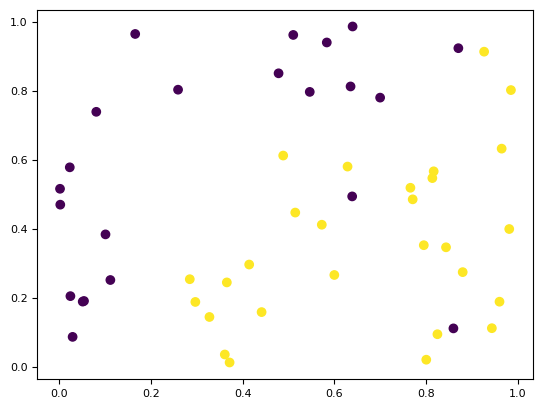

In [169]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


# -------------- START - helper functions --------------

def generate_points(N):
    return np.random.rand(N, 2)


def generate_decision_line():
    g = generate_points(2)
    m = (g[1, 1] - g[1, 0]) / (g[0, 1] - g[0, 0])
    b = g[1, 0] - m * g[0, 0]

    def getY(x):
        return m * x + b

    func = getY
    return func


# This function creates an "unknown" target function f.
# f is then used to create labels y for points X.
# Some of these labels are randomly flipped to render
# the dataset not linearly separable any more.
# X is a matrix containing N rows (the data points) of
# with 2 dimensions (columns) each.
def getClassedPoints(N):
    np.random.seed(5)
    f = generate_decision_line()
    X = generate_points(N)
    y = np.array([1 if f(X[i, 0]) > X[i, 1] else -1
                  for i in range(X.shape[0])])
    for i in np.random.randint(0, len(y), int(len(y) / 10)):
        y[i] = y[i] * (-1)
    return X, y, f


# -------------- END - helper functions --------------

# Obtain data
X_2_2, y_2_2, f = getClassedPoints(50)

# Visualize data
plt.scatter(X_2_2[:, 0], X_2_2[:, 1], c=y_2_2)
plt.show()

(2) Implementieren sie den Pocket-Algorithmus. Nutzen Sie dazu Ihren Code für PLA aus der letzten Übung.
* Hinweis: Sie sind hier bei der Lösung ganz frei. Ich ermutige Sie, sich durch die Aufgabe zu "hacken".

In [170]:
def h(x, w):
    return np.sign(np.dot(x,w))

def E_in(n,m):
    return n / m


def pocket_pla(T, X, y):
    n = X.shape[0]
    x_0 = np.zeros(n)
    X_0 = np.column_stack((x_0,X))
    
    w_roof = w_t = np.zeros(3)
    E_roof = E_t = 1

    for _ in range(1,T):
        classed_wrong = np.where((h(X_0,w_t) != y) == True)
        ind_t = np.random.choice(classed_wrong[0]) # nehme beliebiges Element der falsch Klasssierten
        E_t = E_in(len(classed_wrong[0]), n)     
        
        if E_t < E_roof:
            w_roof = w_t
            E_roof = E_t

        w_t = w_t  + (np.dot(X_0[ind_t],y[ind_t]))
    return w_roof


def p(x, w):
    # return (-w[1]/w[2]) * x - (w[0]/w[2])
    return (w[1]  * x + w[0]) / (-w[2]) 

(3) Wenden Sie Pocket auf den unten gegebenen Datensatz an ($T=1000$) und visualisieren Sie Ihre finale Hypothese (die Gerade) im Scatterplot der Daten.

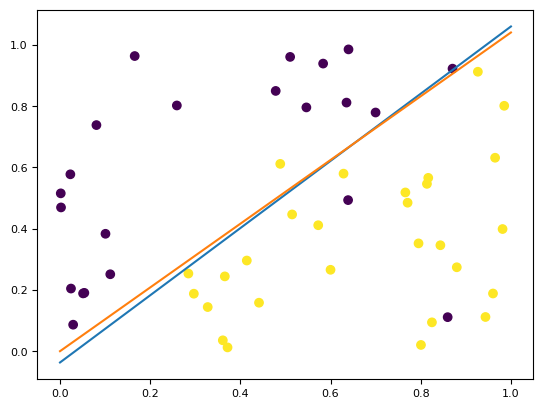

In [171]:
w_res = pocket_pla(1000,X_2_2,y_2_2)
arr = np.array([0,1])

plt.scatter(X_2_2[:, 0], X_2_2[:, 1], c=y_2_2)  
plt.plot(arr, f(arr))
plt.plot(arr, p(arr,w_res))
plt.show()

In [176]:
np.random.choice(5,(2,20))

array([[4, 1, 2, 0, 3, 2, 2, 3, 3, 4, 0, 3, 4, 3, 2, 2, 0, 0, 4, 1],
       [0, 4, 2, 4, 0, 2, 1, 2, 4, 0, 3, 3, 2, 3, 0, 4, 1, 1, 4, 1]])